<a href="https://colab.research.google.com/github/techfreakworm/CustomerChurn/blob/master/TelecomCustomerChurn_Logistic,Tree,Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## For this to work you need first need to get kaggle API token file (kaggle.json) and upload it to your GDRIVE root
!pip install kaggle
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/root/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
if int(status.progress()) == 1:
    print("Kaggle Api install successful")
os.chmod(filename, 600)

Kaggle Api install successful


In [2]:
!kaggle datasets download -d blastchar/telco-customer-churn

telco-customer-churn.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
!mkdir telco
!unzip telco-customer-churn.zip

mkdir: cannot create directory ‘telco’: File exists
Archive:  telco-customer-churn.zip
  inflating: WA_Fn-UseC_-Telco-Customer-Churn.csv  


In [0]:
!mv `ls | grep Churn` telco/

In [5]:
ls telco

WA_Fn-UseC_-Telco-Customer-Churn.csv


In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
data = pd.read_csv('telco/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [8]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

In [10]:
data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [0]:
data = data.dropna()

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

In [13]:
data['OnlineBackup'].value_counts()

No                     3088
Yes                    2429
No internet service    1526
Name: OnlineBackup, dtype: int64

In [0]:
data.loc[data['OnlineSecurity'] == 'No internet service', 'OnlineSecurity'] = 'No'
data.loc[data['OnlineBackup'] == 'No internet service', 'OnlineBackup'] = 'No'
data.loc[data['DeviceProtection'] == 'No internet service', 'DeviceProtection'] = 'No'
data.loc[data['TechSupport'] == 'No internet service', 'TechSupport'] = 'No'
data.loc[data['StreamingTV'] == 'No internet service', 'StreamingTV'] = 'No'
data.loc[data['StreamingMovies'] == 'No internet service', 'StreamingMovies'] = 'No'

In [15]:
data['MultipleLines'].value_counts()

No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64

In [0]:
data.loc[data['MultipleLines'] == 'No phone service', 'MultipleLines'] = 'No'

In [0]:
def tenurify(x):
  if x >= 0 and x <= 12:
    return '0–12 Month'
  elif x > 12 and x <= 24:
    return '12-24 Month'
  elif x > 24 and x <= 48:
    return '24-48 Month'
  elif x > 48 and x <= 60:
    return '48-60 Month'
  else:
    return '>60 Month'
  

data['tenureGroup'] = data['tenure'].apply(tenurify)

In [18]:
data['tenureGroup'].value_counts()

0–12 Month     2186
24-48 Month    1594
>60 Month      1407
12-24 Month    1024
48-60 Month     832
Name: tenureGroup, dtype: int64

In [0]:
data.loc[data['SeniorCitizen'] == 0, 'SeniorCitizen'] = 'No'
data.loc[data['SeniorCitizen'] == 1, 'SeniorCitizen'] = 'Yes'

In [20]:
type(data['TotalCharges'][0])

str

In [21]:
data['TotalCharges'] = data['TotalCharges'].convert_objects(convert_numeric = True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


In [22]:
type(data['TotalCharges'][0])

numpy.float64

In [0]:
analysis_data = data.drop(['customerID','tenure'],axis=1)

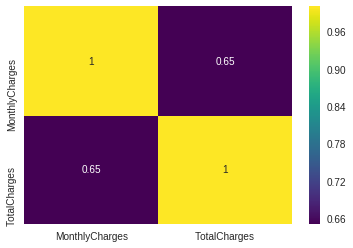

In [24]:
sns.heatmap(analysis_data.corr(), annot=True, cmap='viridis')

In [0]:
analysis_data = analysis_data.drop('TotalCharges', axis=1)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


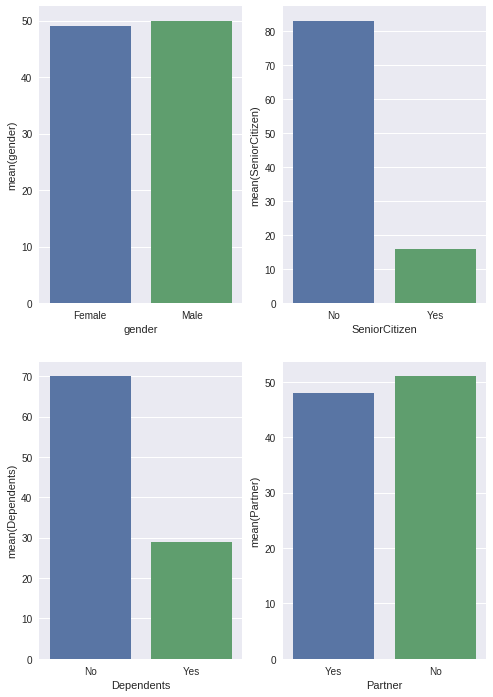

In [26]:
def percentage(x):
  x_valueCounts = x.value_counts()
  x_valueCounts['Total'] = x_valueCounts.sum()
  x_cols = list(x.value_counts().to_dict().keys())
  
  for col in x_cols:
    x_valueCounts[col] = 100*x_valueCounts[col]/x_valueCounts['Total']
    
  y = x.map(x_valueCounts)
  return y


## PLOTTING Gender, SeniorCitizen, Dependents, Partner
fig, axes = plt.subplots(2, 2, figsize=(8,12))
sns.barplot(analysis_data['gender'],percentage(analysis_data['gender']),ax=axes[0,0])
sns.barplot(analysis_data['SeniorCitizen'],percentage(analysis_data['SeniorCitizen']), ax=axes[0, 1])
sns.barplot(analysis_data['Dependents'],percentage(analysis_data['Dependents']), ax=axes[1, 0])
sns.barplot(analysis_data['Partner'],percentage(analysis_data['Partner']), ax=axes[1, 1])


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


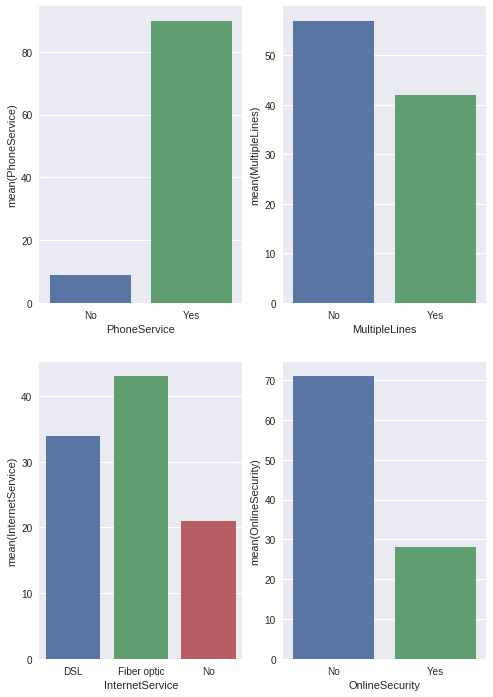

In [27]:
## Plotting for Phone Service, Multiple Lines, Internet Service, Online Security
fig, axes = plt.subplots(2, 2, figsize=(8,12))
sns.barplot(analysis_data['PhoneService'],percentage(analysis_data['PhoneService']),ax=axes[0,0])
sns.barplot(analysis_data['MultipleLines'],percentage(analysis_data['MultipleLines']), ax=axes[0, 1])
sns.barplot(analysis_data['InternetService'],percentage(analysis_data['InternetService']), ax=axes[1, 0])
sns.barplot(analysis_data['OnlineSecurity'],percentage(analysis_data['OnlineSecurity']), ax=axes[1, 1])

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


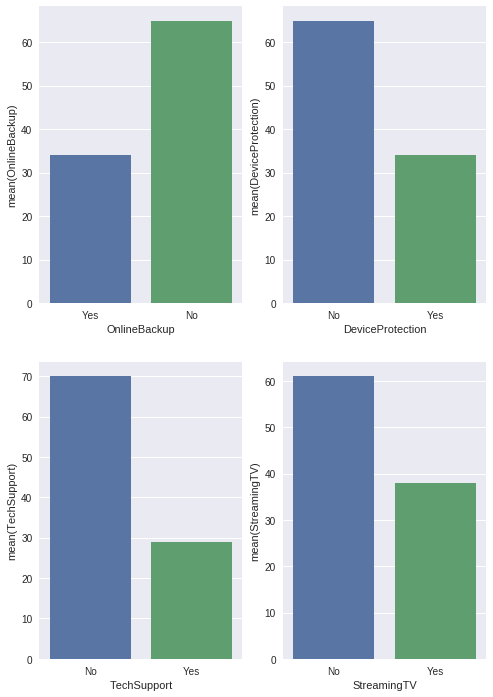

In [28]:
## Plotting for Online Backup, Device Protection, Tech Support, StreamingTV
fig, axes = plt.subplots(2, 2, figsize=(8,12))
sns.barplot(analysis_data['OnlineBackup'],percentage(analysis_data['OnlineBackup']),ax=axes[0,0])
sns.barplot(analysis_data['DeviceProtection'],percentage(analysis_data['DeviceProtection']), ax=axes[0, 1])
sns.barplot(analysis_data['TechSupport'],percentage(analysis_data['TechSupport']), ax=axes[1, 0])
sns.barplot(analysis_data['StreamingTV'],percentage(analysis_data['StreamingTV']), ax=axes[1, 1])

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


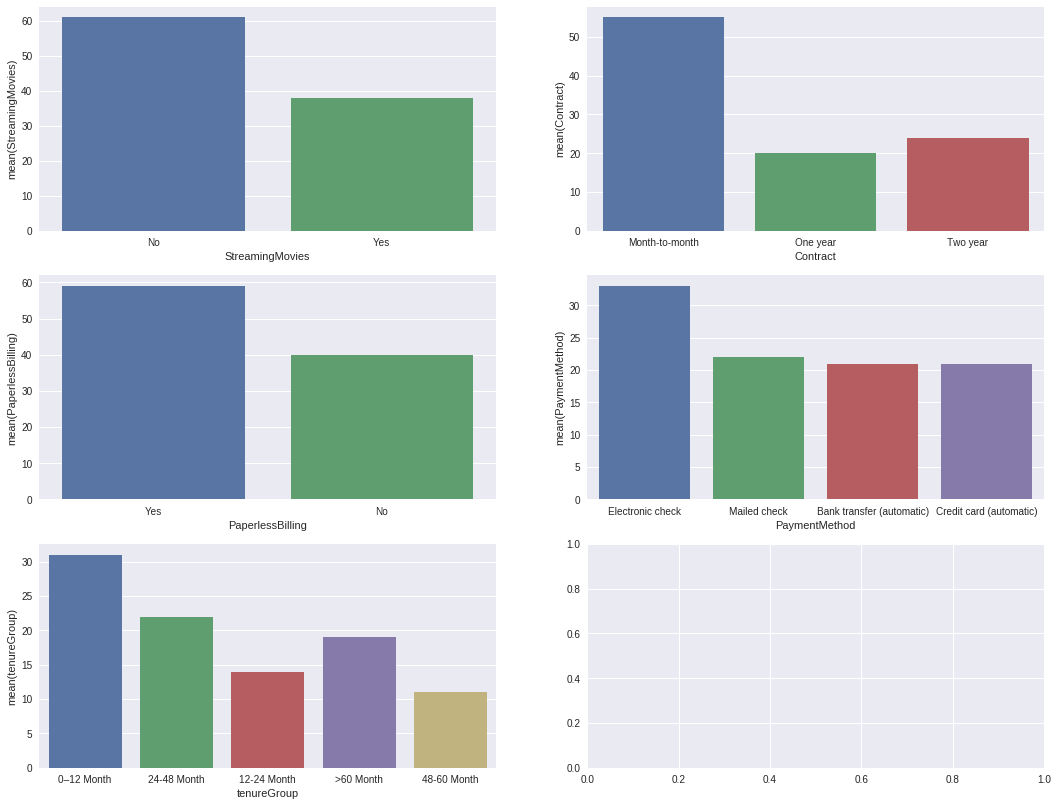

In [29]:
analysis_data.columns

## Plotting for StreamingMovies, Contract, PaperlessBilling, PaymentMethod, Tenure Group
fig, axes = plt.subplots(3, 2, figsize=(18,14))
sns.barplot(analysis_data['StreamingMovies'],percentage(analysis_data['StreamingMovies']),ax=axes[0,0])
sns.barplot(analysis_data['Contract'],percentage(analysis_data['Contract']), ax=axes[0, 1])
sns.barplot(analysis_data['PaperlessBilling'],percentage(analysis_data['PaperlessBilling']), ax=axes[1, 0])
sns.barplot(analysis_data['PaymentMethod'],percentage(analysis_data['PaymentMethod']), ax=axes[1, 1])
sns.barplot(analysis_data['tenureGroup'],percentage(analysis_data['tenureGroup']), ax=axes[2, 0])

## Logistic Regression

In [30]:
analysis_data.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'Churn', 'tenureGroup'],
      dtype='object')

In [0]:
import copy
def stringToIntMapper(dataFrame):
  mappingDict = {}
  convertedDF = pd.DataFrame()
  isColStr = {}
  
  ## Check if column contains string values
  for col in dataFrame.columns:
    if type(dataFrame[col][0]) == str:
      isColStr[col] = True
    else:
      isColStr[col] = False
  
  ## Create mapping dictionary for string values in columns
  for col in dataFrame.columns:
    if isColStr[col]:
      valueList = list(dataFrame[col].value_counts().to_dict().keys())
      counter = 0
      tempValDict = {}
      for val in valueList:
        tempValDict[val] = counter
        counter = counter + 1
      mappingDict[col] = copy.deepcopy(tempValDict)
  
  ## Map the string columns
  for col in dataFrame.columns:
    if isColStr[col]:
      convertedDF[col] = dataFrame[col].map(mappingDict[col])
    else:
      convertedDF[col] = dataFrame[col]
    
  return convertedDF, mappingDict

In [0]:
convertedData, dict = stringToIntMapper(analysis_data)

In [0]:
## Preparing Data
X = convertedData.drop(labels='Churn',axis=1)
y = convertedData['Churn']

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [35]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [36]:
logreg.score(X_test, y_test)

0.7832465688594415

In [37]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, logreg.predict(X_test))
print(confusion_matrix)

[[1377  162]
 [ 296  278]]


In [38]:
import statsmodels.api as sm
logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.437718
         Iterations 7
                         Results: Logit
Model:               Logit            No. Iterations:   7.0000   
Dependent Variable:  Churn            Pseudo R-squared: 0.240    
Date:                2018-12-10 14:32 AIC:              4351.8957
No. Observations:    4930             BIC:              4468.9514
Df Model:            17               Log-Likelihood:   -2157.9  
Df Residuals:        4912             LL-Null:          -2838.9  
Converged:           1.0000           Scale:            1.0000   
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
gender            0.0893   0.0758   1.1786 0.2385 -0.0592  0.2378
SeniorCitizen     0.2015   0.0990   2.0355 0.0418  0.0075  0.3955
Partner          -0.1636   0.0892  -1.8339 0.0667 -0.3384  0.0112


/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Decision Tree Classifier

In [39]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [40]:
tree.score(X_test, y_test)

0.7212494084240416

In [41]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, tree.predict(X_test))
print(confusion_matrix)

[[1244  295]
 [ 294  280]]


## Random Forest Classifier

In [0]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier()

In [43]:
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [44]:
forest.score(X_test, y_test)

0.7662091812588736

In [45]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, forest.predict(X_test))
print(confusion_matrix)

[[1385  154]
 [ 340  234]]
